In [ ]:
# we will need an additional package
!pip install spam

In [1]:
import PIL.Image
import numpy
import scipy.ndimage
import glob
import matplotlib.pyplot as plt

# import spam code for more advanced image adjustments and particle tracking
import spam.DIC
import spam.deformation

# we need data and use an open data set:
# https://doi.org/10.5061/dryad.6djh9w0x8
# this data set is one big zip file and thus unwieldy
# in particular a subset from 2014_08_28_CompressionBiDisperse01
# we will pull from a Zenodo location
import requests



In [ ]:
#if you want to import rom your own drive; use either this block or read the data from Zenodo (next section)
from google.colab import drive
drive.mount('/content/drive')
%cd "/content/drive/My Drive/Colab Notebooks/2014_08_28_CompressionBiDisperse01/"
!pwd
!ls

# import data and sort it by the number in the file name
files = sorted(glob.glob("/content/drive/My Drive/Colab Notebooks/2014_08_28_CompressionBiDisperse01/ImagePostProcessing/ScanRef/*.jpg"))

# Read one file to get 2D dimensions
im = numpy.array(PIL.Image.open(files[0]))

# Allocated empty 3D matrix, 2D dimensions and number of files
im3D = numpy.zeros((len(files), im.shape[0], im.shape[1]))

# build an image stack
for i, file in enumerate(files):
    im3D[i] = numpy.array(PIL.Image.open(files[i]))

In [3]:
# let's fetch the first image in the data from the Zenodo ALERT community page, in the demo data package
url = 'https://zenodo.org/record/7133255/files/0001.jpg?download=1'
r = requests.get(url, allow_redirects=True)
# save the tmp image 
open('imtmp.jpg', 'wb').write(r.content)

# Read one file to get 2D dimensions
im = numpy.array(PIL.Image.open('imtmp.jpg'))

# Allocated empty 3D matrix, 2D dimensions and number of files - we know the data set is 339 images in size
im3D = numpy.zeros((339, im.shape[0], im.shape[1]))

In [4]:
# build an image stack (slow step, takes 5-10 mins)
zenodourl = 'https://zenodo.org/record/7133255/files/'
for i in range(1,339):
  dllink = zenodourl + str("{:04d}".format(i)) + '.jpg?download=1'
  r = requests.get(dllink, allow_redirects=True)
  open('imtmp.jpg', 'wb').write(r.content)
  #save and open the image from the database one by one
  im3D[i] = numpy.array(PIL.Image.open('imtmp.jpg'))
  


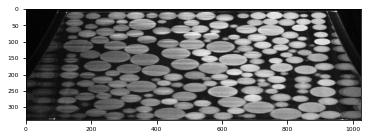

In [5]:
# first show a typical slice from the stack
plt.imshow(im3D[:,im3D.shape[1]//2], cmap='Greys_r');
plt.show()


(339, 358, 358)


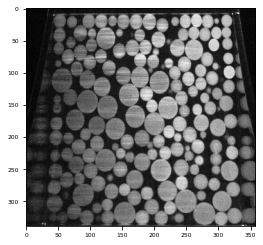

In [6]:
# image is distorted due to change in optical path length. 
# adjust image dimensions to properly represent real dimensions; 
# numbers obtained via manual adjustment and visual inspection
im3Diso = scipy.ndimage.zoom(im3D, [1, 0.35, 0.35])
print(im3Diso.shape)
plt.imshow(im3Diso[:,im3Diso.shape[1]//2], cmap='Greys_r');
plt.show()

**Please note: stretching looks OK, but it's fatter at the bottom**

Measured:
  - W=882 at the Z=end
  - W=802 at the Z=beginning

# Let's apply an increasing un-zoom as we go down Z

0 -- 1.0
100 -- 0.9731648083296435
200 -- 0.9463296166592869
300 -- 0.9194944249889305


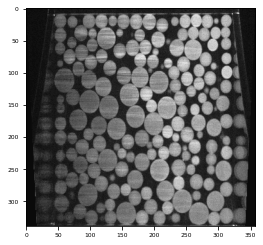

In [7]:
# determine zoom factor manually, just for this demo
zoom = numpy.linspace(1, 1*(802/882), 339)

im3DisoDC = numpy.zeros_like(im3Diso)
for z in range(im3Diso.shape[0]):
    if z%100 == 0: print(f"{z} -- {zoom[z]}")
    im3DisoDC[z] = spam.DIC.applyPhiPython(im3Diso[z][numpy.newaxis, ...], spam.deformation.computePhi({'z': [1, zoom[z], zoom[z]]}))
    
plt.imshow(im3DisoDC[:,im3DisoDC.shape[1]//2], cmap='Greys_r');
plt.show()

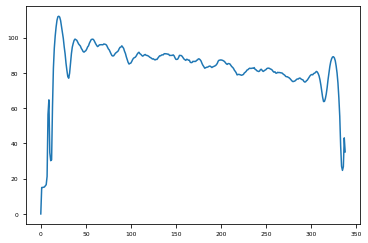

In [8]:
# the background grey levels seem to change on average, as a function of z. 
# We want to correct this for proper thresholding results.
# Let's see how bad it really is.
plt.plot(numpy.median(im3DisoDC[:, 90:300, 50:-50], axis=(1,2)));
plt.show()

# We can do fitting of the slope in intensity by eye!

 - Value = 100 at z=0
 - Value = 75  at z=338

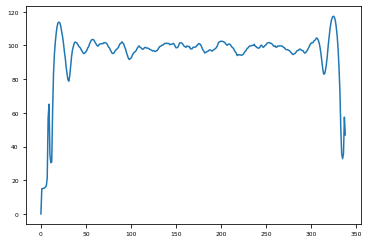

In [9]:
# we will now correct for the background shift by normalizing all grey values by the background factor

correction = numpy.zeros(im3Diso.shape[0])
for z in range(im3DisoDC.shape[0]):
    c = 100 / (100-(25/(339/(z+1)))) # we had observed a 25 pixel change from z=0-338
    correction[z] = c
    #print(f"Correction = {c}")

# print(correction)
# let's see if the correction factor helped to make the original z profile more flat    
plt.plot(correction*numpy.median(im3DisoDC[:, 90:300, 50:-50], axis=(1,2)));
plt.show()



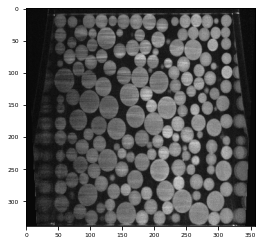

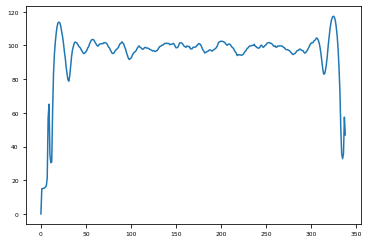

In [10]:
# Apply correction to im3Diso:
im3DisoDC_GC = numpy.zeros_like(im3DisoDC)
for z in range(im3DisoDC.shape[0]):
    im3DisoDC_GC[z] = im3DisoDC[z] * correction[z]
plt.imshow(im3DisoDC_GC[:,im3DisoDC_GC.shape[1]//2], cmap='Greys_r');
plt.show()

# So now it's flat?
plt.plot(numpy.median(im3DisoDC_GC[:, 90:300, 50:-50], axis=(1,2)));
plt.show()

Having normalized the overall background, now we can do fun stuff such as detecting particles. To see them more clearly, we can threshold the image at the appropriate level. The appropriate level can be obtained from a histogram of pixel values in a typical image.

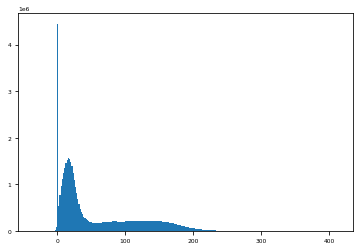

In [11]:
# make histogram
plt.hist(im3DisoDC_GC.ravel(), bins=256)
plt.show()


From the histogram we can see that the bright areas (representing particles) mostly have pixel values below 50. We therfore think that a threshold of 50 will be appropriate for thresholding

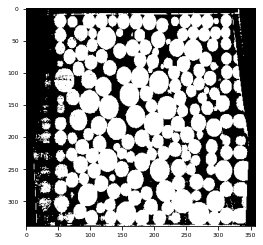

In [12]:
# do thresholding at level T = 50
T = 50
plt.imshow(im3DisoDC_GC[:,im3Diso.shape[1]//2] > T, cmap='Greys_r');
plt.show()

The particles are now clearly delineated, but the image needs some cleaning to get rid of junk at the edges, from reflections and other artefacts.

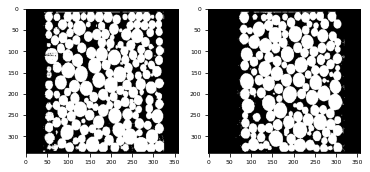

In [13]:

# we make a thresholded binary 3D image stack
im3DisoDC_GC_binary = im3DisoDC_GC.copy() > T
im3DisoDC_GC_binary[0:9] = 0
im3DisoDC_GC_binary[-3::] = 0

# set various edges to zero to clean up the artefacts we do not want to further analyze
im3DisoDC_GC_binary[:, :, 0:40] = 0
im3DisoDC_GC_binary[:, :, 323::] = 0
plt.subplot(1,2,1)
plt.imshow(im3DisoDC_GC_binary[:,im3Diso.shape[1]//2], cmap='Greys_r');

im3DisoDC_GC_binary[:, 0:60] = 0
im3DisoDC_GC_binary[:, 320::] = 0

# let's see how this looks via a plot with two subpanels.
plt.subplot(1,2,2)
plt.imshow(im3DisoDC_GC_binary[:,:,im3Diso.shape[2]//2], cmap='Greys_r');
plt.show()

We are now ready to label particles in the image via spam

In [14]:
import spam.label
lab = spam.label.watershed(im3DisoDC_GC_binary)

There are 1955 particles


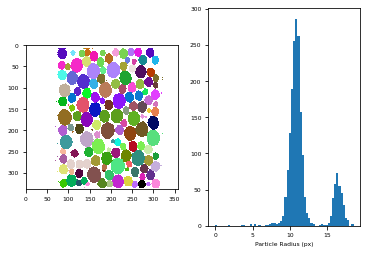

In [15]:
# let's check some results

print(f"There are {lab.max()} particles")
plt.subplot(1,2,1)
plt.imshow(lab[:,:,im3Diso.shape[2]//2], cmap=spam.label.randomCmap, interpolation='none')

# Compute the radius of the sphere of the same volume as each particle
particleRadii = spam.label.equivalentRadii(lab)

plt.subplot(1,2,2)
plt.hist(particleRadii, bins=64)
plt.xlabel("Particle Radius (px)")
plt.show()

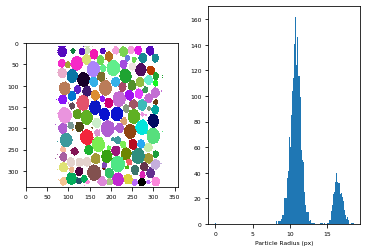

In [16]:
# Tidy up too-small particles
lab = spam.label.removeLabels(lab, numpy.where(particleRadii < 8))
lab = spam.label.makeLabelsSequential(lab)

# Recompute radii
particleRadii = spam.label.equivalentRadii(lab)

plt.subplot(1,2,1)
plt.imshow(lab[:,:,im3Diso.shape[2]//2], cmap=spam.label.randomCmap, interpolation='none')

# The experimental description here suggested that the particles used were a bidisperse mixture. We can now verify that was indeed the case
plt.subplot(1,2,2)
plt.hist(particleRadii, bins=128)
plt.xlabel("Particle Radius (px)")
plt.show()

From here you can do what you want with the data via all the functionalities from spam...